In [1]:
import zipfile  # 处理压缩文件
import os

import pandas as pd  # 处理 csv 文件
import numpy as np
from matplotlib import pyplot as plt
import d2lzh as d2l
from mxnet import nd, init
from mxnet.gluon import nn

# ----- 自定义模块
from utils.zipimage import ImageZ
from utils.gluonxinet import loader
%matplotlib inline


def get_net(ctx):
    # 创建模型
    model = nn.HybridSequential()
    model.add(
        nn.BatchNorm(), nn.Activation('relu'),   # 批量归一化
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(32, (3, 3)),              # 32 个卷积核尺寸为 (3，3)
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(64, (3, 3)),              # 64 个卷积核尺寸为 (3，3)
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(128, (3, 3)),              # 128 个卷积核尺寸为 (3，3)
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(512, kernel_size=1),  # 1 x 1 卷积 进行降维
        nn.BatchNorm(), nn.Activation('relu'),
        nn.GlobalAvgPool2D(),             # 全局平均池化
        nn.Dense(2)       # 输出层

    )
    return model

dataDir = 'data/dog_cat'
os.listdir(dataDir)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['results.csv', 'sampleSubmission.csv', 'test1.zip', 'train.zip']

In [2]:
testset = ImageZ(dataDir, 'test1') # 测试数据
class_names = ('cat', 'dog')
ctx = d2l.try_gpu()
net = get_net(ctx)   # 在 ctx 上训练

net.load_parameters('models/0.9112-dog_cat-99-best.params')
net.collect_params().reset_ctx(ctx)
net.hybridize()

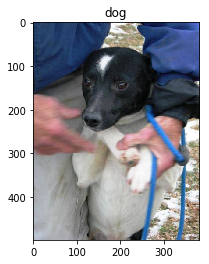

In [3]:
for img in testset:
    X = loader.transform_test(nd.array(img)).expand_dims(axis=0).as_in_context(ctx)
    y = net(X)
    label = class_names[y.argmax(1).astype('int').asscalar()]
    plt.imshow(img)
    plt.title(label)
    plt.show()
    break

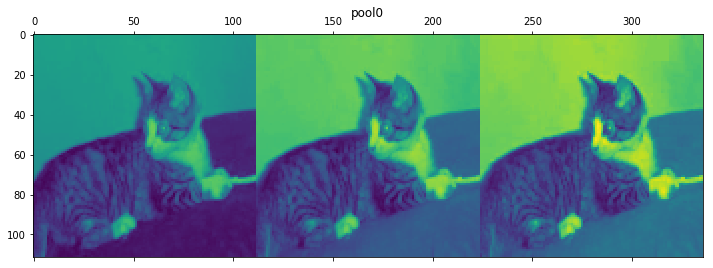

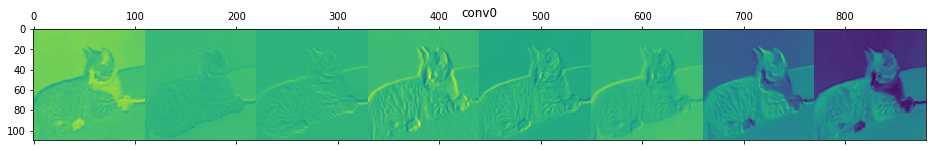

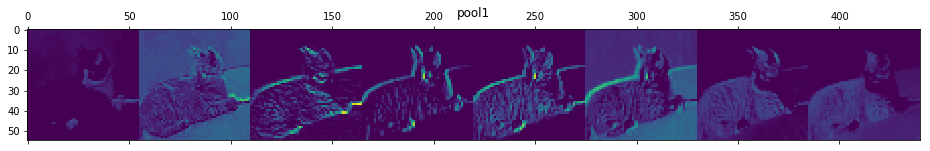

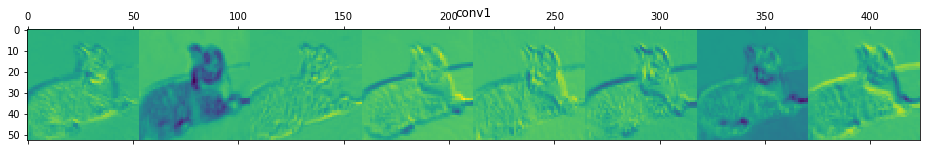

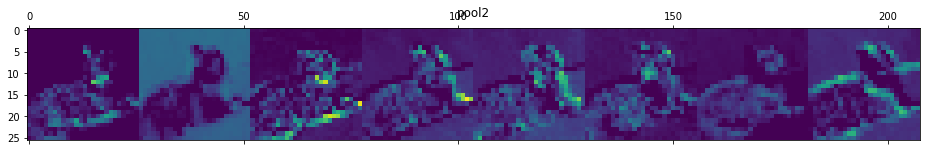

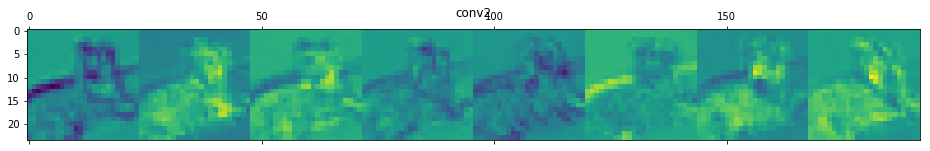

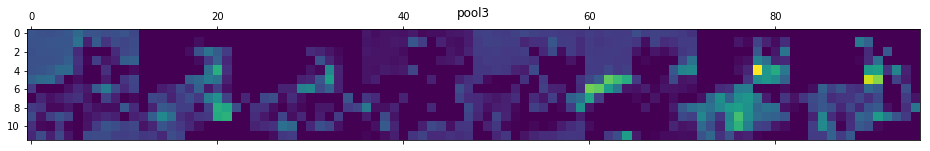

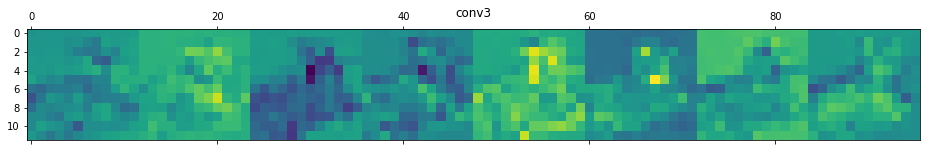

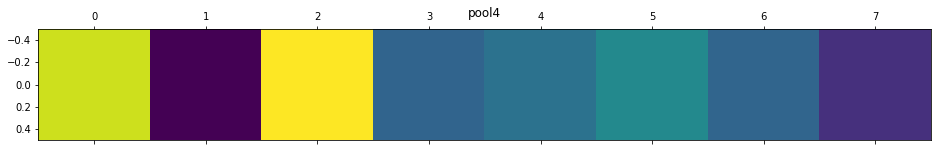

In [4]:
X = loader.transform_test(nd.array(testset[10])).expand_dims(axis=0).as_in_context(ctx)
for layer in net:
    X = layer(X)
    if layer.name.startswith('pool') or layer.name.startswith('conv'):
        K = X.asnumpy()[0]
        size = K.shape[0]
        if size == 3:
            imgs = np.concatenate(K, axis=-1)
        else:
            i = 0
            while i <= size // 8:
                imgs = np.concatenate(K[i:i+8], axis=-1)
                i += 8
        plt.matshow(imgs, cmap='viridis')
        plt.title(layer.name)
        plt.show()